In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.data as data

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale

random_generator = np.random.default_rng()

In [5]:
def get_mask(r = 1):
    x = y = np.arange(nx)
    xx, yy = np.meshgrid(x, y)
    
    return ((xx - nx/2)**2 + (yy - nx/2)**2 < (r * nx/2)**2).astype(float)

def get_image():
    u = 0.5 * np.float64(data.binary_blobs(length=nx, blob_size_fraction=0.5))
    u += 0.5 * np.float64(data.binary_blobs(length=nx, blob_size_fraction=0.2))
   
    mask = get_mask(r=0.9)
    u *= mask
   
    return u


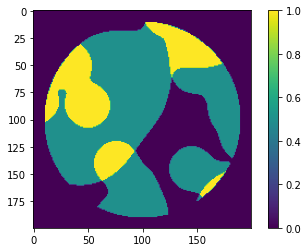

In [6]:
nx = 200
plt.imshow(get_image())
plt.colorbar()

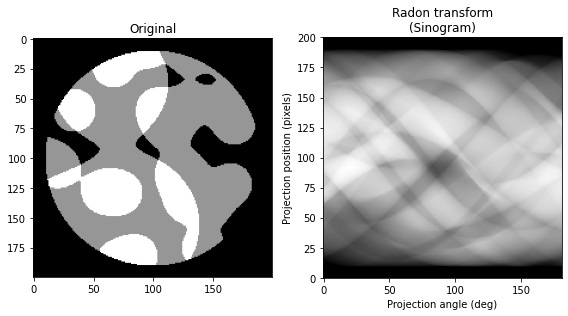

In [7]:
# image = shepp_logan_phantom()
# image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)
image = get_image()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()

FBP rms reconstruction error: 0.0345


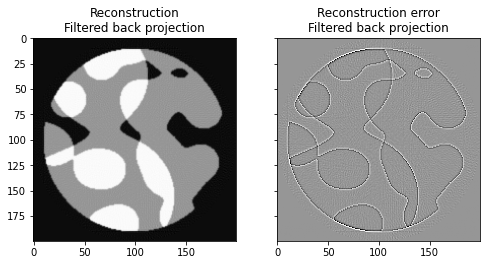

In [8]:
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

FBP rms reconstruction error: 0.302


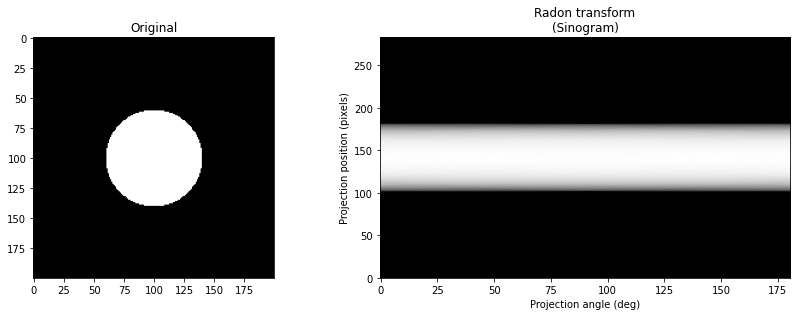

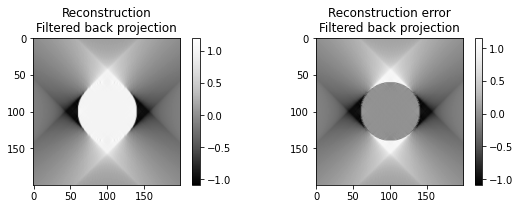

In [9]:
sparse_view = False
few_detectors = False
sparsity = 2
limited_angle = True
noisy = False

image = get_mask(r=0.4)
# image = get_image()

# TODO: improve the noise generation
if noisy:
    image += 0.2 * np.random.randn(*image.shape)
    image *= get_mask(r=0.4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

min_angle = -45.0 if limited_angle else 0.0
max_angle = 45.0 if limited_angle else 180.0
num_angles = 16 if sparse_view else max(image.shape)

theta = np.linspace(min_angle, max_angle, num_angles, endpoint=False)
sinogram = radon(image, theta=theta, circle=False)

if few_detectors:
    sinogram = sinogram[::sparsity]
    # We can try interpolating in the sinogram space
    # sinogram = cv2.resize(sinogram, (sparsity * sinogram.shape[0], sinogram.shape[1]), interpolation=cv2.INTER_LINEAR)

reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp', circle=False)

if few_detectors:
    # We can also try interpolating in the image space
    reconstruction_fbp = cv2.resize(reconstruction_fbp, 
                                    (sparsity * reconstruction_fbp.shape[0], sparsity * reconstruction_fbp.shape[1]), 
                                    interpolation=cv2.INTER_LINEAR)
    
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.set_title("Reconstruction\nFiltered back projection")
reconstructed_img = ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.colorbar(reconstructed_img, ax=ax1)

ax2.set_title("Reconstruction error\nFiltered back projection")
error_img = ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r)
plt.colorbar(error_img, ax=ax2)

fig.tight_layout()
plt.show()

In [10]:
# def plot_reconstructed_image(image, theta, title_str):
#     sinogram = radon(image, theta=theta, circle=False)
#     reconstruction = iradon(sinogram, theta=theta, filter_name='ramp', circle=False)

#     fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

#     ax1.set_title(title_str)
#     ax1.imshow(reconstruction, cmap=plt.cm.Greys_r)
    
#     error = reconstruction - image
#     print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

#     fig.tight_layout()
#     plt.show()

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

#     ax1.set_title("Reconstruction\nFiltered back projection")
#     reconstructed_img = ax1.imshow(reconstruction, cmap=plt.cm.Greys_r)
#     plt.colorbar(reconstructed_img, ax=ax1)

#     ax2.set_title("Reconstruction error\nFiltered back projection")
#     error_img = ax2.imshow(reconstruction - image, cmap=plt.cm.Greys_r)
#     plt.colorbar(error_img, ax=ax2)

#     fig.tight_layout()
#     plt.show()
    
# # Limited angle reconstruction:
# image = get_mask(r=0.4)
# theta = np.linspace(-45.0, 45.0, max(image.shape), endpoint=False)
# plot_reconstructed_image(image, theta)

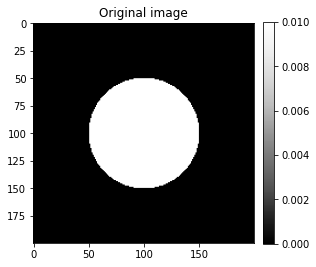

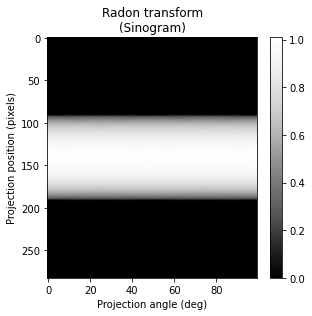

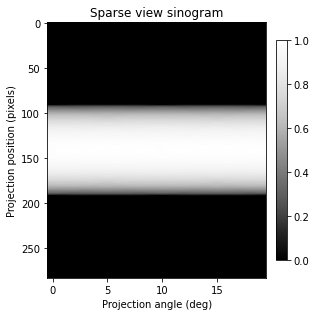

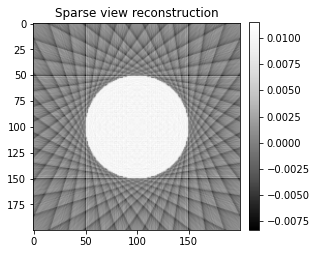

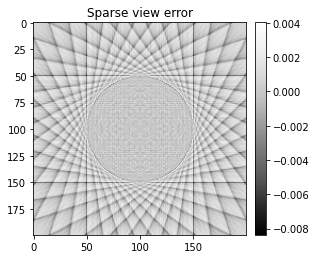

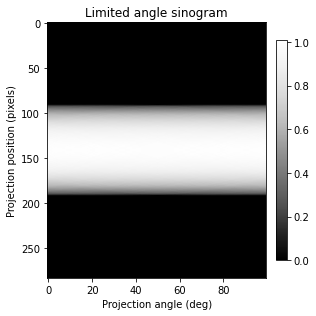

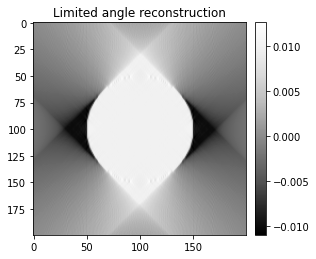

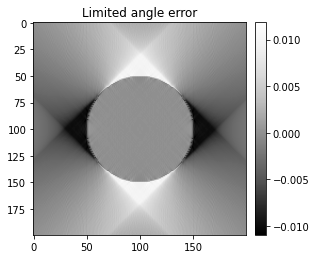

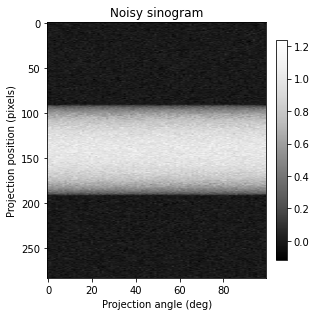

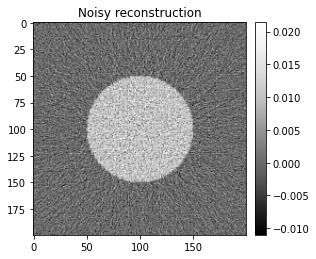

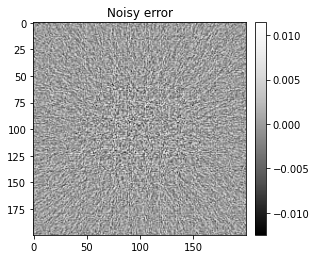

In [17]:
# 
# Output the original image to img_orig.png and show
# 

size = 4.5

img = 0.01 * get_mask(r=0.5)

fig, ax = plt.subplots(1, 1, figsize=(size, size))

ax.set_title("Original image")
img_orig = ax.imshow(img, cmap=plt.cm.Greys_r)
plt.colorbar(img_orig,fraction=0.046, pad=0.04)

fig.tight_layout()
plt.savefig('img_orig.png')
plt.show()

# 
# Output the sinogram to img_sinogram and show
# 

fig, ax = plt.subplots(1, 1, figsize=(size, size))

orig_sinogram = radon(img, theta=theta, circle=False)

ax.set_title("Radon transform\n(Sinogram)")
ax.set_xlabel("Projection angle (deg)")
ax.set_ylabel("Projection position (pixels)")
img_sinogram = ax.imshow(orig_sinogram, cmap=plt.cm.Greys_r,
                         aspect='auto')
plt.colorbar(img_sinogram, ax=ax)

fig.tight_layout()
plt.savefig('img_sinogram')
plt.show()

def sparse_view():
    theta = np.linspace(0, 180, 20, endpoint=False)
    sinogram = radon(img, theta=theta, circle=False)
    
    return ('Sparse view', img, sinogram, theta)

def limited_angle():
    theta = np.linspace(-45., 45., max(img.shape)//2, endpoint=False)
    sinogram = radon(img, theta=theta, circle=False)
    
    return ('Limited angle', img, sinogram, theta)

def noisy():
    theta = np.linspace(0, 180, max(img.shape)//2, endpoint=False)
    
    sinogram = radon(img, theta=theta, circle=False)
    I_0 = 1000
    
    # Our computed sinogram data assumes that I = I_0 * d, where 
    # d is the survival probability of a single photon. It is more
    # realistic to model I as Poisson distributed with mean
    # I_0 * d, so we modify the sinogram data to conform to this.
    I = random_generator.poisson(I_0 * np.exp(-sinogram))
    sinogram = -np.log(I / I_0)
    
    # Alternatively, we could approximate the Poisson distribution
    # by a Gaussian distribution. This gives more or less the same
    # result.
    # sinogram = random_generator.normal(
    #     sinogram, 1/ np.sqrt((I_0 * np.exp(-sinogram))))
    
    return ('Noisy',
            img,
            sinogram,
            theta)

for mode in [sparse_view, limited_angle, noisy]:
    title_str, img, sinogram, theta = mode()
    save_str = title_str.lower().replace(' ', '_')
    
    #Save the sinogram to file, and show.
    fig, ax = plt.subplots(1, 1, figsize=(size, size))

    ax.set_title(f"{title_str} sinogram")
    ax.set_xlabel("Projection angle (deg)")
    ax.set_ylabel("Projection position (pixels)")
    img_sinogram = ax.imshow(sinogram, cmap=plt.cm.Greys_r,
                             aspect='auto')
    plt.colorbar(img_sinogram, ax=ax, fraction=0.046, pad=0.04)

    fig.tight_layout()    
    plt.savefig(f"{save_str}_sinogram")
    plt.show()
    
    # Compute the reconstruction, save to file, and show.
    reconstruction = iradon(sinogram, theta=theta, 
                            filter_name='ramp', circle=False)
    
    fig, ax = plt.subplots(1, 1, figsize=(size, size))
    ax.set_title(f"{title_str} reconstruction")
    reconstructed_img = ax.imshow(reconstruction, cmap=plt.cm.Greys_r)
    plt.colorbar(reconstructed_img, ax=ax, fraction=0.046, pad=0.04)
    
    fig.tight_layout()
    plt.savefig(f"{save_str}_reconstruction")
    plt.show()
    
    # Compute the error, save to file, and show.
    error = reconstruction - img
    
    fig, ax = plt.subplots(1, 1, figsize=(size, size))
    ax.set_title(f"{title_str} error")
    error_img = ax.imshow(error, cmap=plt.cm.Greys_r)
    plt.colorbar(error_img, ax=ax, fraction=0.046, pad=0.04)
    
    fig.tight_layout()
    plt.savefig(f"{save_str}_error")
    plt.show()


## Trying to make Normal distribution parameters fit Poisson distribution parameters

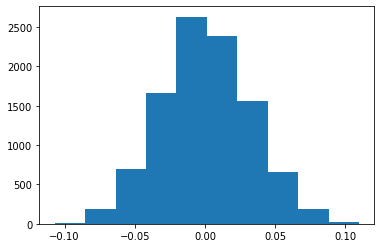

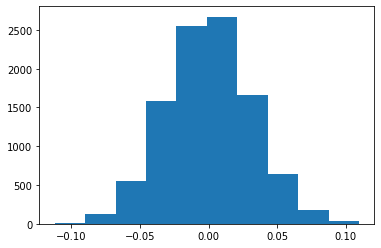

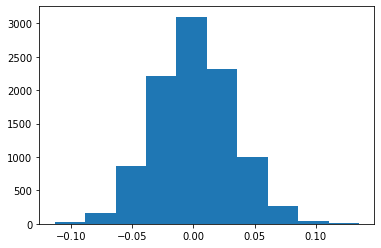

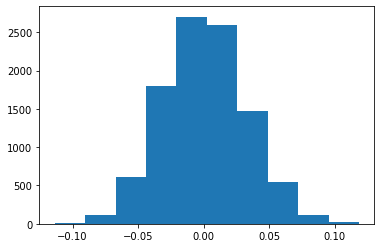

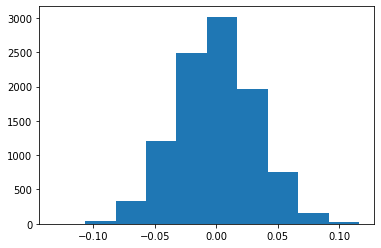

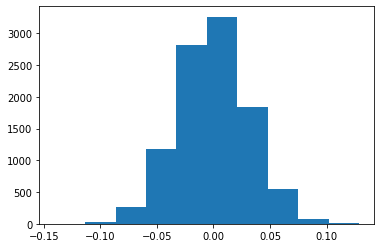

In [12]:
N = 10000

I_0 = 1000
line_integral = 0
d = np.exp(-line_integral)

# First method: sample I from P(I_0 * d), and compute -log(I / I_0)
I1 = random_generator.poisson(I_0 * d, size=N)
b1 = -np.log(I1 / I_0)
plt.hist(b1)
plt.show()

# Second method: sample Z from N(0, 1), 
# compute I = I_0d + sqrt(I_0 d)Z, compute -log(I / I_0)

Z2 = random_generator.normal(size=N)
I2 = I_0 * d + np.sqrt(I_0 * d) * Z2
b2 = -np.log(I2 / I_0)
plt.hist(b2)
plt.show()

# Third method: sample Z from N(0, 1)
# compute b = -log(d + sqrt(I_0 * d) / I_0 * Z)
Z3 = random_generator.normal(size=N)
b3 = -np.log(d + np.sqrt(I_0 * d) / I_0 * Z3)
plt.hist(b3)
plt.show()

# Fourth method: sample Z
# compute b = -log(d) - log(1 + 1/(sqrt(I_0 d)) * Z)
Z4 = random_generator.normal(size=N)
b4 = -np.log(d) - np.log(1 + 1/np.sqrt(I_0 * d) * Z4)
plt.hist(b4)
plt.show()

# Fifth method: sample Z
# Compute -log(d) - 1/sqrt(I_0 * d) * Z
Z5 = random_generator.normal(size=N)
b5 = -np.log(d) - 1/np.sqrt(I_0 * d) * Z5
plt.hist(b5)
plt.show()

# Last method: sample b from N(line_integral, 1/(I_0 * d))
# NB: the second argument of numpy's Generator.normal() is the 
# standard deviation sigma, NOT the variance sigma^2 which is common
# in math notation.
b6 = random_generator.normal(line_integral, 1/(np.sqrt(I_0 * d)), size=N)
plt.hist(b6)
plt.show()


# I = random_generator.poisson(I_0 * d, size=N)
# vals1 = -np.log(I/I_0)
# plt.hist(vals1)
# plt.show()

# print(np.var(I))
# print(f"Should be {I_0 * d}")

# I_p = I_0 * d + np.sqrt(I_0 * d) * random_generator.normal(size=N)
# plt.hist(-np.log(I_p/I_0))
# plt.show()

# I_n = d + np.sqrt(I_0 * d) / I_0 * random_generator.normal(size=N)
# val2 = -np.log(d)

# vals2 = random_generator.normal(line_integral, 1/(I_0 * d), size=10000)
# plt.hist(vals2)
# plt.show()

# print(np.var(vals2))
# print(np.sqrt(I_0 * d))